# Numerical simulation of the wave equation in 2D using Finite Difference

## Import libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML
import sys

----

## Create domain model properties (i.e. speed of waves), and discretisation grid

In [2]:
# 501 grid-points along the x-axis, 351 along the z-axis
nx = 501
nz = 351

# start with homogeneous model - same wave-speed everywhere.
c = np.full((nx,nz),1500.0)  # Note: 1500m/s is typical acoustic velocity of water

# a faster layer, deeper in model, to show reflection of waves when crossing sharp interface
#c[:,140:] = 3000.0  # Note: 3000m/s is fairly typical acoustic velocity of sedimentary rock

print('Range of speeds:  %.1fm/s to %.1fm/s' % (c.min(),c.max()))

Range of speeds:  1500.0m/s to 1500.0m/s


In [3]:
length = 3500.0 # assign a length to the model in metres

dx = length/(nx-1) # calculate the spatial increment between model parameters

depth = dx*(nz-1) # calculate the depth from the length and number of x and z gridpoints

print('Domain is %d x %d grid-points (%.1fm x %.1fm)' % (nx,nz,length,depth))
print('Grid-spacing (dx) is %.2fm' % (dx))

Domain is 501 x 351 grid-points (3500.0m x 2450.0m)
Grid-spacing (dx) is 7.00m


In [4]:
def plot_model(c):
    plt.figure(figsize=(10,6))
    plt.imshow(c.T) # plotting the velocity model (note transposed, to orient plot in way we expect)
    plt.colorbar()
    plt.xlabel('x gridpoints')
    plt.ylabel('z gridpoints')
    plt.title('Velocity model (m/s)')
    plt.show()

def plot_slice(c,xgrid):
    plt.figure(figsize=(7,6))
    plt.plot(c[xgrid,:],range(nz-1,-1,-1))  # note two arrays, 2nd one (range) gets model on x axis
    plt.xlabel('propagation speed / m/s')
    plt.ylabel('z gridpoints')
    plt.title('Vertical slice through model at x-gridpoint=%d' % xgrid)
    plt.show()

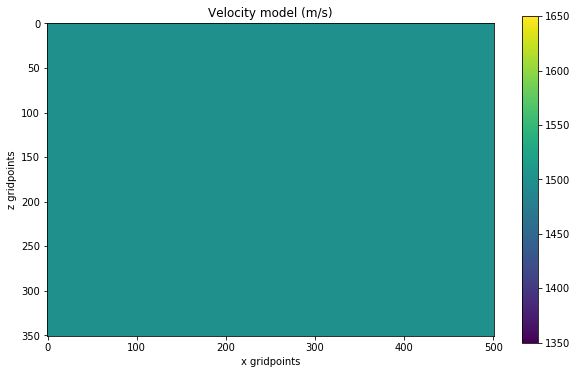

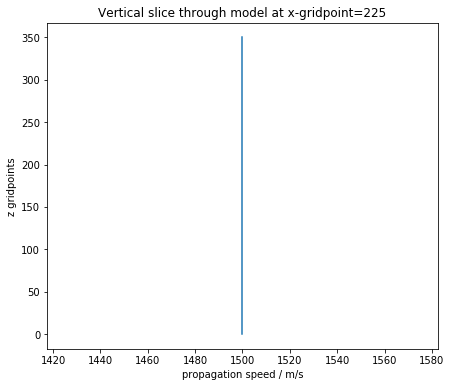

In [5]:
plot_model(c)
plot_slice(c,225)

----
## Modelling constraints
#### CFL stability condition should be satisfied – the 'Courant number'.

The dimensionless Courant number, $C$, gives a measure of how far a signal will travel across a grid-cell (/between grid-points) within one time-step.
(Hence why I will very often refer to it as 'the crossing factor'.)

The crossing factor is $c$.$\delta t$/$\delta x$ for speed $c$, and we want the maximum value of this within the whole domain to satisfy some constraint that depends upon the finite-difference stencil(s) in use when modelling.

i.e. we want:$\quad \text{max}(c)$.$\delta t/\delta x <= C_{max}$, where $\ C_{max}$ depends on the discretisations.

We can turn this around to find the maximum time-step for our model and grid-spacing, given $C_{max}$ for our discretisations:

$$\delta t_{best} = \frac{C_{max}\ \delta x}{\text{max}(c)}$$

#### This spatial stencil (simple 2nd order), with 2nd-order time-stepping, requires the max crossing factor to (usually) be no more than sqrt(1/2)
(i.e. can only cross up to 70.7% of a cell in one time-step – we'll use 70% here...)

In [6]:
courant = 0.70  # set the dimensionless max Courant number for 2nd-order FD grid in space & time

In [7]:
time = 2.0  # desired length of the simulation in seconds
dt = (courant*dx)/c.max()  # define the best time-step by using the max Courant number
nt = int(time/dt+0.9999)  # how many steps are needed to cover that time
time = nt*dt  # turn that back into exact time for this number of steps
print('Time-step = %.5fs  Number of steps = %d  (Total time being modelled: %.5fs)' % (dt,nt,dt*nt))

Time-step = 0.00327s  Number of steps = 613  (Total time being modelled: 2.00247s)


### Create source function (Ricker wavelet with 8Hz peak frequency)

In [8]:
# want to locate the source in the grid
sx = 150
sz = 80

The Ricker wavelet used here is a function of time that's defined from the second derivate of a Gaussian function (which is $G(t)=\text{e}^{-a^2 t^2}$).

–It's also known as the Mexican hat wavelet, due to its shape when plotted as a function of two variables.

It can be written so it is symmetric about time zero, with maximum at that time, ultimately decaying towards zero as $t$$\rightarrow$$±\infty$. However, we will shift it in time so that it starts near zero at our time zero.

After differentiating above Gaussian, $G(t)$, twice, flipping, then scaling (and before shifting in time), we get: $\quad R(t) = (1-2a^2 t^2)\ \text{e}^{-a^2 t^2}$

The peak frequency of the Ricker wavelet is at $f$=$a/\pi$.

The length of the wavelet, in time, before it decays close enough to zero for our purposes, is about $\frac{2.1}{f}$ (i.e. about $\frac{1.05}{f}$ seconds each side of the wavelet's central peak).

In [9]:
def create_ricker(freq,dt,ampl):
    ts = 2.1/freq  # desired length of wavelet in time is related to peak frequency
    ns = int(ts/dt+0.9999)  # figure out how many time-steps are needed to cover that time
    ts = ns*dt  # and now turn that back into a time that's exactly the required number of steps
    print('Length of wavelet will be %.5f secs (%d steps)' % (ts,ns))
    a2 = (freq*np.pi)**2  # a squared (see equation above)
    t0 = ts/2 - dt/2  # midpoint time of wavelet
    src = np.zeros(ns)
    # create Ricker wavelet (see equation above), offset by time t0 (so midpoint of wavelet is at time t=t0)
    for i in range(ns):
        src[i] = ampl*( (1 - 2*a2*((i*dt-t0)**2)) * np.exp(-a2*((i*dt-t0)**2)) )
    print('Endpoint values are: %.6f %.6f' % (src[0],src[-1]))
    return src,ns

In [10]:
freq = 8.0  # let's create an 8Hz Ricker source wavelet
src,ns = create_ricker(freq,dt,1.0)

Length of wavelet will be 0.26460 secs (81 steps)
Endpoint values are: -0.000426 -0.000426


In [11]:
def plot_source(src):
    plt.figure(figsize=(10,6))
    plt.plot(src) # plot source wavelet
    plt.xlabel('timesteps')
    plt.ylabel('amplitude')
    plt.title('Source Wavelet (Ricker, peak %.1fHz)' % (freq))
    plt.show()

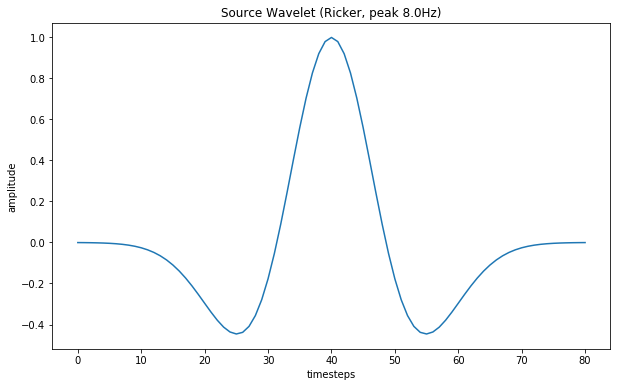

In [12]:
plot_source(src)

### Check that the maximum frequency in the source wavelet can propagate reliably

For a simple second-order finite-difference, the minimum wavelength of a signal that we can propagate reliably is about 10 cells.

In [13]:
min_cells_per_wl = 10.0  # minimum of 10 cells per wavelength for reasonably accurate propagation
max_freq = c.min()/(min_cells_per_wl*dx) # calculate the max frequency that can be modelled without numerical dispersion
print('Maximum reliable propagation frequency is about %.1fHz' % max_freq)

Maximum reliable propagation frequency is about 21.4Hz


#### Want to avoid causing too much dispersion by keeping maximum significant frequency within this limit...

In [14]:
# plot amplitude spectrum of source wavelet
def plot_ampl_spect(src):
    plt.figure(figsize=(10,6))
    plt.magnitude_spectrum(np.append(src,np.zeros(nt-ns)), Fs=1/dt)  # note padding to nt points
    plt.title('Amplitude Spectrum')
    plt.xlim(0,35)
    plt.show()

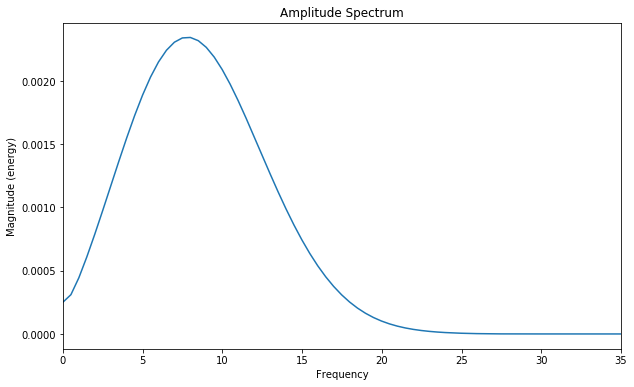

In [15]:
plot_ampl_spect(src)

----
## Create absorbing layers

$$\text{With absorbing layers, the 2nd-order time discretisation for the 2d wave equation becomes:}$$

$$(1+q)\ u^{\tau+1}(x,z)\ \approx \ \delta t^2c(x,z)^2\ 
\left(\frac{\partial^2 u^\tau(x,z)}{\partial x^2}+\frac{\partial^2 u^\tau(x,z)}{\partial z^2}\right)+\ (2-q^2)\ u^\tau(x,z)\ -\ 
(1-q)\ u^{\tau-1}(x,z)$$

$$\text{Where:}\quad q\ =\ \alpha \frac{c(x,z)\delta t}{\delta x}\quad
\text{(note that we've set the grid-spacing to be $\delta x$ in $z$ direction as well as $x$)}$$

>**Task 1:**
>
>You've already seen the time-discretisation in 1d with absorbing layers, and you've discretised the 2d wave equation for space & time in the previous notebook.
>
>That means you should now be able to take the equations above and see how you will have to modify the code in the time-stepping (that will be the next task). But before doing that we must first build the absorbing layer coefficients in the same kind of way we did for the 1d case...
>
>**The array `a` currently gets created in the code cell below so it contains all zeros (one for each gridpoint in the 2d domain). Now create a layer of 60 gridpoints all around the edges of the domain where `a` will contain value 1.0 instead of zero.**  
>
>**Make the appropriate changes to the code in the time-stepping loop to include the absorption, then try it out.**  
>– We saw before that abruptly switching on the absorbing layer like this would produce reflections from where the absorption begins – we need to ramp it up more slowly, just like we did in 1d...
>
>**As we did with 1d earlier, now have a linear ramp in the 60-gridpoint absorbing layer, so that it goes from zero up to one when it reaches the domain boundary.**  
>– This should be a big improvement over the sudden switch-on above.  
>– Once you tweak `absfact` up to nearer 0.1 again, you should see less reflection from the domain edges.
>
>**Change the code again to try a quadratic ramp from zero to one (rather than linear).**  
>– As before, you should see this is an improvement over the linear above.  

In [16]:
# This array will eventually contain the 'q' from the equation given above, but only after
# it has been multiplied by the c.dt/dx, and by the scaling factor 'absfact'.
# Before then, any values it contains only need to be in range zero to one.

a = np.zeros((nx,nz))  # initialise array with zeros


# FILL IN CODE HERE TO BUILD ABSORBING LAYERS, AROUND ALL EDGES OF THE DOMAIN (task 1)...


# CONSTANT

a[:60,:]  = 1.0  # left layer
a[-60:,:] = 1.0  # right layer

a[:,:60]  = 1.0  # top layer
a[:,-60:] = 1.0  # bottom layer

#a[:,-80:]  = 1.0  # uncomment to make bottom layer 80 grid-points instead of 60

absfact = 0.04  # this will be the initial scaling factor we'll try for the absorbing layers


In [32]:
# LINEAR

a = np.zeros((nx,nz))  # initialise array with zeros

# left and right absorbing layers
for i in range(1,61):  # sixty grid-points in layers
    a[60-i,:]   = 1.0*i/60  # linear increase towards left boundary
    a[i-60-1,:] = 1.0*i/60  # linear increase towards right boundary

# top and bottom absorbing layers
for i in range(1,61):  # sixty grid-points in layer
    for j in range(nx):
        a[j,60-i]   = max(a[j,60-i],   1.0*i/60) # linear increase towards top boundary
        a[j,i-60-1] = max(a[j,i-60-1], 1.0*i/60) # linear increase towards bottom boundary

# uncomment below to make bottom layer 80 grid-points instead of 60...
#for i in range(1,81):  # try 80 grid-points in bottom layer
#    for j in range(nx):
#        a[j,i-81]   = max(a[j,i-81], 1.0*i/80)  # linear increase towards bottom boundary

absfact = 0.08  # initial scaling-factor to try for linear ramp


In [49]:
# QUADRATIC

a = np.zeros((nx,nz))  # initialise array with zeros

abswid = 60  # 60 grid-points absorbing layer
absw2 = abswid*abswid  # useful shorthand

# left and right absorbing layers
for i in range(1,abswid+1):  # sixty grid-points in layers
    a[abswid-i,:]   = 1.0*i*i/absw2  # quadratic increase towards left boundary
    a[i-abswid-1,:] = 1.0*i*i/absw2  # quadratic increase towards right boundary

# top and bottom absorbing layers
for i in range(1,abswid+1):  # sixty grid-points in layer
    for j in range(nx):
        a[j,abswid-i]   = max(a[j,abswid-i],   1.0*i*i/absw2)  # quadratic increase towards top boundary
        a[j,i-abswid-1] = max(a[j,i-abswid-1], 1.0*i*i/absw2)  # quadratic increase towards bottom boundary


# uncomment below to make bottom layer 80 grid-points instead of 60...
for i in range(1,81):  # try 80 grid-points in bottom layer
    for j in range(nx):
        a[j,i-81]   = max(a[j,i-81], 1.0*i*i/(80*80))  # quadratic increase towards bottom boundary

        
absfact = 0.1  # initial scaling-factor to try for quadratic ramp


#### Show the absorption model

In [50]:
# various plots so you can check your absorption model...

def plot_absorbing(a):
    plt.figure(figsize=(10,6))
    plt.title('Absorption')

    plt.imshow(a.T) # plotting the absorption as a 2d colour plot (note transposed, to orient plot in way we expect)
    plt.colorbar()
    plt.xlabel('x gridpoints')
    plt.ylabel('z gridpoints')

    plt.show()


def plot_absorb_horiz(a,zgrid):
    plt.figure(figsize=(8,4))
    plt.title('Horizontal x-section at z-gridpoint=%d' % zgrid)

    plt.plot(a[:,zgrid])  # horizontal cross-section through absorption, to show const/linear/quadratic nature
    plt.xlabel('x gridpoints')
    plt.ylabel('absorption coefficient')

    plt.show()


def plot_absorb_vert(a,xgrid):
    plt.figure(figsize=(8,4))
    plt.title('Vertical x-section at x-gridpoint=%d' % xgrid)

    plt.plot(a[xgrid,:])  # vertical cross-section through absorption, to show const/linear/quadratic nature
    plt.xlabel('z gridpoints')
    plt.ylabel('absorption coefficient')

    plt.show()

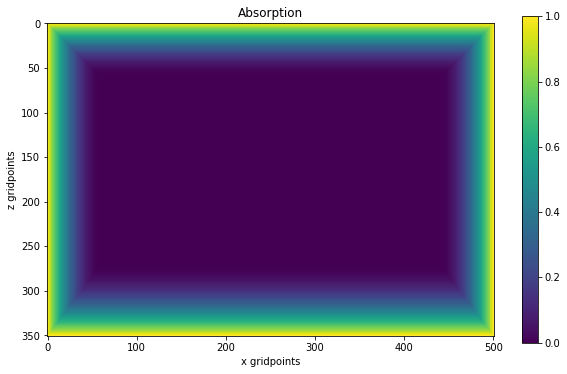

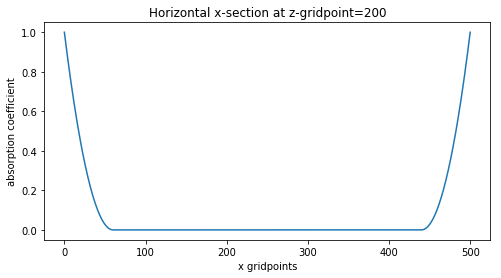

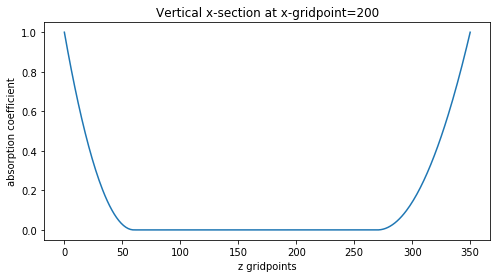

In [51]:
plot_absorbing(a)
plot_absorb_horiz(a,200)
plot_absorb_vert(a,200)

Finish by scaling with velocity and other factors, for direct use in simulation later

In [52]:
#absfact = 0.0  # to switch off absorbing layer

a[:,:] = a[:,:]*c[:,:]*(dt/dx)*absfact

## Line of receivers within domain
–To detect what crosses a particular horizontal line of the domain (i.e. constant depth) over time

In [53]:
rz = 70  # put receiver line at depth of seventy cells (just above source point)
r = np.zeros((nx,nt))  # an array to store receiver data every step (and to plot later)

----
# Simulation

In [54]:
# Initialise arrays for wavefields
u = np.zeros((nx,nz)) # current wavefield
u_prv = np.zeros((nx,nz)) # old t-1 wavefield
u_nxt = np.zeros((nx,nz)) # new t+1 wavefield

In [55]:
# prepare an array to store wavefield snapshots for plotting
snapshot_gap = 10 # set sampling rate used to store wavefield (every 10 timesteps)
wavefield = np.zeros((int(nt/snapshot_gap), nx, nz)) # array to store wavefields every 10 timesteps
print('Storing %d wavefields (every %dth out of %d)' % (wavefield.shape[0],snapshot_gap,nt))

Storing 61 wavefields (every 10th out of 613)


In [56]:
# a useful variable – shorthand for something that appears regularly in expressions below
dtdx2 = (dt*dt)/(dx*dx)

In [57]:
u[sx,sz] = src[0]  # inject first source entry into current wavefield


# begin time-stepping loop...

for i in range(nt):
    
    if (i+1)%20==0:  # show progress every 20 steps
        sys.stdout.write('Done step %d (of %d)\r' % (i+1,nt))
    
    
    # CHANGE LINE OF CODE BELOW TO INCLUDE ABSORPTION (see task 1)...

    # find new wavefield, u_new, throughout domain (apart from edges)
    u_nxt[1:-1,1:-1] = ( (2-a[1:-1,1:-1]**2)*u[1:-1,1:-1] - (1-a[1:-1,1:-1])*u_prv[1:-1,1:-1]  \
        + (c[1:-1,1:-1]**2)*dtdx2*(u[:-2,1:-1]+u[2:,1:-1]-4*u[1:-1,1:-1]+u[1:-1,:-2]+u[1:-1,2:]) )  \
                  /  (1+a[1:-1,1:-1])


    # inject source entry for this step at the source point
    if i+1<ns:
        u_nxt[sx,sz] = src[i+1]
    
    # shift wavefields for next time-step
    u_prv[:,:] = u[:,:]
    u[:,:] = u_nxt[:,:]
    
    # fill in values at receivers
    r[:,i] = u[:,rz]

    if (i+1)%snapshot_gap == 0: # store the current wavefield u on every tenth step
        wavefield[int((i+1)/snapshot_gap-1)] = u[:,:]

print('Finished %d time-steps' % (nt))

Finished 613 time-steps


## Plot wavefield at different times

In [58]:
def plot_snapshot(plot_time,bounds):
    plt.figure(figsize=(10,7))
    plt.imshow(wavefield[int(plot_time/(dt*snapshot_gap))].T,   # note the wavefield was transposed
               vmin=-bounds, vmax=bounds, cmap='RdBu', interpolation='bilinear')
    plt.title('Wavefield at about %.2fs' % (plot_time))
    plt.colorbar()
    plt.xlabel('x gridpoints')
    plt.ylabel('z gridpoints')
    plt.show()

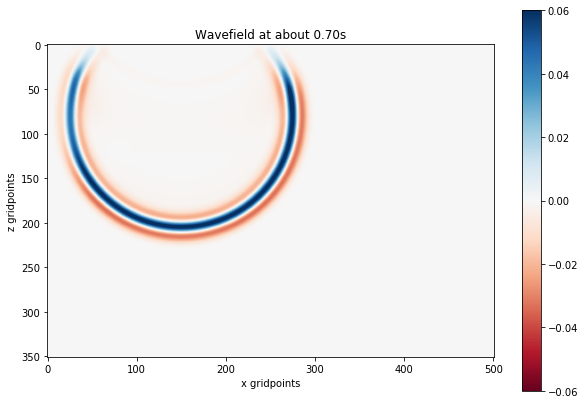

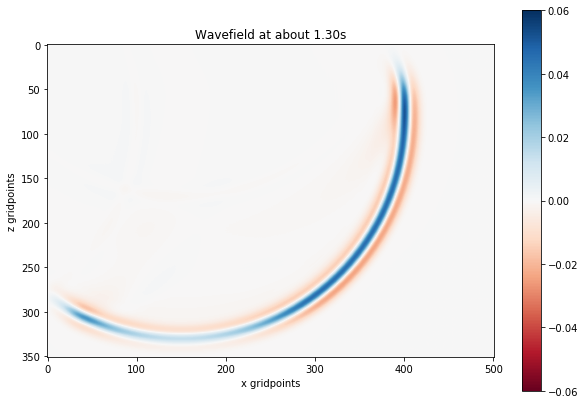

In [59]:
plot_snapshot(0.7,0.06)
plot_snapshot(1.3,0.06)

## Plot data at receivers

In [60]:
def plot_at_receivers(bounds):
    plt.figure(figsize=(10,7))
    plt.imshow(r.T, cmap='RdBu', interpolation='bilinear', aspect='auto', 
               vmin=-bounds, vmax=bounds,   # set bounds for colourmap data
               extent=(0,nx,time,0))  # set bounds for axes
    plt.title('Receiver Data')
    plt.colorbar()
    plt.xlabel('Receiver number')
    plt.ylabel('Time / s')
    plt.show()

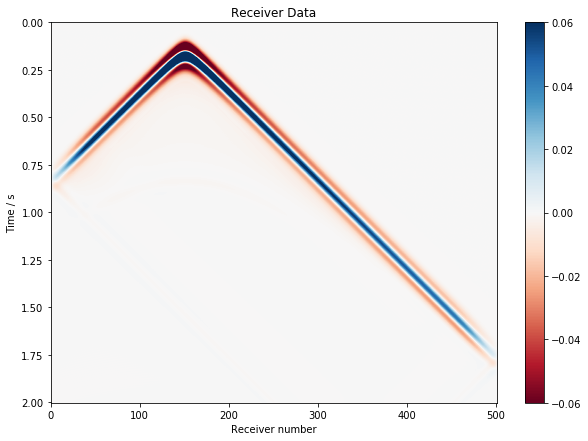

In [61]:
plot_at_receivers(0.06)

## Make a movie! 

In [62]:
def create_animation(bounds):
    fig = plt.figure(figsize=(10,8))

    plt.title('Wavefield')
    plt.xlabel('x gridpoints')
    plt.ylabel('z gridpoints')

    n = wavefield.shape[0]
    imgs = []
    for i in range(n):
        if i%20==0:  # show progress every 20 frames
            sys.stdout.write('Done %d of %d\r' % (i+1,n))
        img = plt.imshow(wavefield[i].T, vmin=-bounds, vmax=bounds, cmap='RdBu',
                         animated=True, interpolation='bilinear')
        imgs.append([img])

    print('Finished plots for frames, building animation...')

    ani = anim.ArtistAnimation(fig, imgs, interval=50, blit=True)

    plt.close(fig)  # prevent final frame plot from showing up inline below

    return ani

In [63]:
ani = create_animation(0.06)
print('Preparing HTML (takes a little while...)')
HTML(ani.to_jshtml())

Finished plots for frames, building animation...
Preparing HTML (takes a little while...)
